In [1]:
# Load helper packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import string
import xgboost

#import sklearn.datasets
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import sklearn.svm as svm

from utils import *
from sklearn.model_selection import GridSearchCV,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost
from xgboost import XGBClassifier

import pickle

from timeit import default_timer as timer

from sklearn.metrics import roc_auc_score,roc_curve
from auc_delong_xu import auc_ci_Delong

import statistics as stats

import cac_consortium_functions as cac_consortium_functions

import lime
import lime.lime_tabular

import shap

%load_ext autoreload
%autoreload 2

In [2]:
# Set seed
randomSeed = 42

# Set death ratio
deathRatio = 1.0

# Set threshold
classifierThreshold = 0.5

# Toggles
toggleRegenerateTrainTestSplit= 0

# Splits
numTrainValidationSplits= 1

In [3]:
# Read structured data file
cac_data, out_var = cac_consortium_functions.read_and_structure()

# Split data
strFilePostfix='_2020-03-17'
strFileExt='.csv'
strFilenameTrainValidation='train_cac_data'+strFilePostfix+strFileExt
strFilenameTest           ='test_cac_data' +strFilePostfix+strFileExt
if toggleRegenerateTrainTestSplit:
    training_validation_cac_data, testing_cac_data = cac_consortium_functions.split_data(cac_data, randomSeed)
    training_validation_cac_data.to_csv(strFilenameTrainValidation, index = False)
    testing_cac_data.to_csv(strFilenameTest, index = False)
else:
    training_validation_cac_data=pd.read_csv(strFilenameTrainValidation, low_memory=False)
    testing_cac_data=pd.read_csv(strFilenameTest, low_memory=False)

if 1:
    # Check
    listNameSplit=['Original','Train-Valid','Test']
    listDataSplit=[cac_data,training_validation_cac_data,testing_cac_data]
    cac_consortium_functions.check_subsampled_split_data(listNameSplit,listDataSplit)
    cac_consortium_functions.check_stratified_split_data(listNameSplit,listDataSplit)

Headings: ['index', 'age', 'total_score', 'Deathtenytruncated']

----------------------
Match Indices Train-Valid in Original
----------------------
Match=100.00% (50572), NoMatch=0.00% (0), Size=50572
Split[0]:idx= 4022, age=76.51, score=  12,death=0-> Orig[ 4022]:age=76.51, score=  12,death=0| Match=True
Split[1]:idx=27407, age=80.17, score= 566,death=0-> Orig[27407]:age=80.17, score= 566,death=0| Match=True
Split[2]:idx=12244, age=50.00, score=   0,death=0-> Orig[12244]:age=50.00, score=   0,death=0| Match=True
----------------------
Match Indices Test in Original
----------------------
Match=100.00% (12643), NoMatch=0.00% (0), Size=12643
Split[0]:idx=21482, age=46.13, score=  69,death=0-> Orig[21482]:age=46.13, score=  69,death=0| Match=True
Split[1]:idx=17482, age=67.23, score=   0,death=0-> Orig[17482]:age=67.23, score=   0,death=0| Match=True
Split[2]:idx=11064, age=46.00, score=   0,death=0-> Orig[11064]:age=46.00, score=   0,death=0| Match=True

----------------------
Verify S

In [4]:
# No Training-Validation split but place then into a list of size one
dataFileTrain = training_validation_cac_data
dataFileTest  = testing_cac_data

In [5]:
# Balance cac training data
dataFileTrainBalanced = cac_consortium_functions.balance_training_data(dataFileTrain, deathRatio, out_var, randomSeed)  

# Log transform total score + 1
dataFileTrainLog = dataFileTrain.copy()
dataFileTrainLog['total_score'] = np.log(dataFileTrainLog['total_score'] + 1)

dataFileTestLog = dataFileTest.copy()
dataFileTestLog['total_score'] = np.log(dataFileTestLog['total_score'] + 1)

dataFileTrainBalancedLog = dataFileTrainBalanced.copy()
dataFileTrainBalancedLog['total_score'] = np.log(dataFileTrainBalancedLog['total_score'] + 1)

# Age x score interaction term
dataFileTrainInteract = dataFileTrain.copy()
dataFileTrainInteract['total_score_x_age'] = dataFileTrainInteract['total_score'] * dataFileTrainInteract['age']

dataFileTestInteract = dataFileTest.copy()
dataFileTestInteract['total_score_x_age'] = dataFileTestInteract['total_score'] * dataFileTestInteract['age']

dataFileTrainLogInteract = dataFileTrainLog.copy()
dataFileTrainLogInteract['total_score_x_age'] = dataFileTrainLogInteract['total_score'] * dataFileTrainLogInteract['age']

dataFileTestLogInteract = dataFileTestLog.copy()
dataFileTestLogInteract['total_score_x_age'] = dataFileTestLogInteract['total_score'] * dataFileTestLogInteract['age']

dataFileTrainBalancedInteract = dataFileTrainBalanced.copy()
dataFileTrainBalancedInteract['total_score_x_age'] = dataFileTrainBalancedInteract['total_score'] * dataFileTrainBalancedInteract['age']

dataFileTrainBalancedLogInteract = dataFileTrainBalancedLog.copy()
dataFileTrainBalancedLogInteract['total_score_x_age'] = dataFileTrainBalancedLogInteract['total_score'] * dataFileTrainBalancedLogInteract['age']
   
if 1:
    # Check
    listNameSplit=['Original','Train(Unbal)','Train(Bal)']
    listDataSplit=[cac_data, dataFileTrain, dataFileTrainBalanced]
    cac_consortium_functions.check_subsampled_split_data(listNameSplit, listDataSplit)
    
    listNameSplit=['Original', 'Tr(Unbal)', 'Tr(Bal)', 'Tr(Unbal,Log)', 'Tr(Bal,Log)']
    listDataSplit=[cac_data, dataFileTrain, dataFileTrainBalanced,
                   dataFileTrainLog, dataFileTrainBalancedLog]
    cac_consortium_functions.check_stratified_split_data(listNameSplit, listDataSplit)
    
    listNameSplit=['Original','Test','Test(Log)']
    listDataSplit=[cac_data, dataFileTest, dataFileTestLog]
    cac_consortium_functions.check_stratified_split_data(listNameSplit, listDataSplit)

Headings: ['index', 'age', 'total_score', 'Deathtenytruncated']

----------------------
Match Indices Train(Unbal) in Original
----------------------
Match=100.00% (50572), NoMatch=0.00% (0), Size=50572
Split[0]:idx= 4022, age=76.51, score=  12,death=0-> Orig[ 4022]:age=76.51, score=  12,death=0| Match=True
Split[1]:idx=27407, age=80.17, score= 566,death=0-> Orig[27407]:age=80.17, score= 566,death=0| Match=True
Split[2]:idx=12244, age=50.00, score=   0,death=0-> Orig[12244]:age=50.00, score=   0,death=0| Match=True
----------------------
Match Indices Train(Bal) in Original
----------------------
Match=100.00% (3802), NoMatch=0.00% (0), Size=3802
Split[0]:idx=19496, age=70.00, score=  36,death=1-> Orig[19496]:age=70.00, score=  36,death=1| Match=True
Split[1]:idx=38961, age=71.79, score= 930,death=1-> Orig[38961]:age=71.79, score= 930,death=1| Match=True
Split[2]:idx= 2043, age=60.00, score=  34,death=1-> Orig[ 2043]:age=60.00, score=  34,death=1| Match=True

----------------------
Ver

In [6]:
# XGBoost trained on Unbalanced Training-Validation Cac Data
# Tested on Testing Cac data with a classifier of 0.5
# With log transforming score and interaction term
print('XGBoost, Unbalanced, Log, Interaction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data(
       dataFileTrainLogInteract, dataFileTestLogInteract, out_var, togglePrintNormalization,
       toggleInteraction = 1)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 1)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, classifierThreshold)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy)

print('FeatImport:',modelGSCV.best_estimator_.feature_importances_)  

# listFeatureNamesXGBInteract=listFeatureNames.copy()
# listDataTrainXGBInteract=listDataTrain.copy()
# listDataTrainUnnormXGBInteract=listDataTrainUnnorm.copy()
# listModelGSCVXGBInteract=listModelGSCV.copy()

XGBoost, Unbalanced, Log, Interaction
1:Age+Score  age                       Mean:  54.4-> 0.0, Std:  10.5-> 1.0, Range:[ 19.9, 100.1]->[ -3.3,  4.4]
1:Age+Score  total_score               Mean:   2.3->-0.0, Std:   2.5-> 1.0, Range:[  0.0,   9.4]->[ -0.9,  2.8]
1:Age+Score  total_score_x_age         Mean: 139.0-> 0.0, Std: 160.7-> 1.0, Range:[  0.0, 787.3]->[ -0.9,  4.0]
Fitting Model: Age+Score , Split: 0, Time(s): 30.1, Saved as PKLfiles\SavedModel_AgeSc
[ TP, FP ]=[   11,   17]
[ FN, TN ]=[  464,12151]
Pos  =   475	
Neg  = 12168	Sens =   2%	PPV  =  39%	
Pop  = 12643	Spec = 100%	NPV  =  96%	
Prev =     4%	Acc  =  96%	AUC = 0.7948 +/- 0.0129 CI(95%):[0.4587,0.5092]
MCC = 0.09	
FeatImport: [0.5896042  0.10961897 0.30077687]


In [7]:
# XGBoost trained on UnBalanced Training-Validation Cac Data with no interaction and log transform
# Tested on Testing Cac data with a classifier of 0.5
print('XGBoost, Unbalanced, Log, NoInteraction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data(
       dataFileTrainLog, dataFileTestLog, out_var, togglePrintNormalization,
       toggleInteraction = 0)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 1)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, classifierThreshold)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy)

print('FeatImport:',modelGSCV.best_estimator_.feature_importances_)

XGBoost, Unbalanced, Log, NoInteraction
1:Age+Score  age                       Mean:  54.4-> 0.0, Std:  10.5-> 1.0, Range:[ 19.9, 100.1]->[ -3.3,  4.4]
1:Age+Score  total_score               Mean:   2.3->-0.0, Std:   2.5-> 1.0, Range:[  0.0,   9.4]->[ -0.9,  2.8]
Fitting Model: Age+Score , Split: 0, Time(s): 22.8, Saved as PKLfiles\SavedModel_AgeSc
[ TP, FP ]=[   12,   15]
[ FN, TN ]=[  463,12153]
Pos  =   475	
Neg  = 12168	Sens =   3%	PPV  =  44%	
Pop  = 12643	Spec = 100%	NPV  =  96%	
Prev =     4%	Acc  =  96%	AUC = 0.7965 +/- 0.0129 CI(95%):[0.4583,0.5088]
MCC = 0.10	
FeatImport: [0.74593216 0.25406784]


In [8]:
# Shap
shap.initjs()
indPat = 829 #142
xgb = modelGSCV

train_data = pd.DataFrame(train_data, columns = ['age', 'total_score'])
test_data = pd.DataFrame(test_data, columns = ['age', 'total_score'])

train_dataset = train_data_norm
test_dataset = test_data_norm
train_dataset = pd.DataFrame(train_dataset, columns = ['age', 'total_score'])
test_dataset = pd.DataFrame(test_dataset, columns = ['age', 'total_score'])

xgb_explainer = shap.TreeExplainer(xgb.best_estimator_, train_dataset, feature_perturbation='interventional')
shap_values = xgb_explainer.shap_values(test_dataset.loc[indPat,:])
print("XGBoost, Unbalanced, No Interaction, Log Transformed Score")
print("Index: ", indPat)
print("Shap Values [age, total_score]:", shap_values)
print("Probabilities [not death, death]: ", xgb.best_estimator_.predict_proba(test_data_norm)[indPat,:])
shap.force_plot(xgb_explainer.expected_value, shap_values, dataFileTest.loc[indPat,['age', 'total_score']])

Passing 50572 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


XGBoost, Unbalanced, No Interaction, Log Transformed Score
Index:  829
Shap Values [age, total_score]: [ 2.40151284 -0.17893986]
Probabilities [not death, death]:  [0.8311828  0.16881722]


In [9]:
# XGBoost trained on Balanced Training-Validation Cac Data with no interaction and log transform
# Tested on Testing Cac data with a classifier of 0.5
print('XGBoost, Balanced, Log, NoInteraction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data(
       dataFileTrainBalancedLog, dataFileTestLog, out_var, togglePrintNormalization,
       toggleInteraction = 0)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 1)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, classifierThreshold)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy)

print('FeatImport:',modelGSCV.best_estimator_.feature_importances_)

XGBoost, Balanced, Log, NoInteraction
1:Age+Score  age                       Mean:  59.8->-0.0, Std:  12.4-> 1.0, Range:[ 21.7,  94.0]->[ -3.1,  2.8]
1:Age+Score  total_score               Mean:   3.3-> 0.0, Std:   2.8-> 1.0, Range:[  0.0,   9.0]->[ -1.2,  2.0]
Fitting Model: Age+Score , Split: 0, Time(s): 2.7, Saved as PKLfiles\SavedModel_AgeSc
[ TP, FP ]=[  320, 2907]
[ FN, TN ]=[  155, 9261]
Pos  =   475	
Neg  = 12168	Sens =  67%	PPV  =  10%	
Pop  = 12643	Spec =  76%	NPV  =  98%	
Prev =     4%	Acc  =  76%	AUC = 0.7956 +/- 0.0129 CI(95%):[0.4631,0.5136]
MCC = 0.19	
FeatImport: [0.7054193  0.29458073]


In [10]:
# Shap
shap.initjs()
indPat = 829 #142
xgb = modelGSCV

train_data = pd.DataFrame(train_data, columns = ['age', 'total_score'])
test_data = pd.DataFrame(test_data, columns = ['age', 'total_score'])

train_dataset = train_data_norm
test_dataset = test_data_norm
train_dataset = pd.DataFrame(train_dataset, columns = ['age', 'total_score'])
test_dataset = pd.DataFrame(test_dataset, columns = ['age', 'total_score'])

xgb_explainer = shap.TreeExplainer(xgb.best_estimator_, train_dataset, feature_perturbation='interventional')
shap_values = xgb_explainer.shap_values(test_dataset.loc[indPat,:])
print("XGBoost, Balanced, No Interaction, Log Transformed Score")
print("Index: ", indPat)
print("Shap Values [age, total_score]:", shap_values)
print("Probabilities [not death, death]: ", xgb.best_estimator_.predict_proba(test_data_norm)[indPat,:])
shap.force_plot(xgb_explainer.expected_value, shap_values, dataFileTest.loc[indPat,['age', 'total_score']])

XGBoost, Balanced, No Interaction, Log Transformed Score
Index:  829
Shap Values [age, total_score]: [ 1.51427219 -0.45291972]
Probabilities [not death, death]:  [0.23863137 0.76136863]


Passing 3802 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


In [11]:
# Logistic regression trained on Unbalanced Training-Validation Cac Data without interaction term
# Tested on Testing Cac data with a classifier of 0.5
# With Log transformed score
print('LogReg, Unbalanced, Log, NoInteraction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data_logistic(
       dataFileTrainLog, dataFileTestLog, out_var, togglePrintNormalization,
       toggleInteraction = 0)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training_logistic(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 0)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, classifierThreshold)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy)

print('Coefficients:',modelGSCV.best_estimator_.coef_[0])
print('Intercept   :',modelGSCV.best_estimator_.intercept_[0])
    
# listFeatureNamesLGR=listFeatureNames.copy()
# listDataTrainLGR=listDataTrain.copy()
# listDataTrainUnnormLGR=listDataTrainUnnorm.copy()
# listModelGSCVLGR=listModelGSCV.copy()

LogReg, Unbalanced, Log, NoInteraction
1:Age+Score  age                       Mean:  54.4->54.4, Std:  10.5->10.5, Range:[ 19.9, 100.1]->[ 19.9,100.1]
1:Age+Score  total_score               Mean:   2.3-> 2.3, Std:   2.5-> 2.5, Range:[  0.0,   9.4]->[  0.0,  9.4]
[ TP, FP ]=[    1,    2]
[ FN, TN ]=[  474,12166]
Pos  =   475	
Neg  = 12168	Sens =   0%	PPV  =  33%	
Pop  = 12643	Spec = 100%	NPV  =  96%	
Prev =     4%	Acc  =  96%	AUC = 0.7962 +/- 0.0129 CI(95%):[0.4616,0.5123]
MCC = 0.02	
Coefficients: [0.08558066 0.15206429]
Intercept   : -8.855735685583012


In [12]:
# Shap
shap.initjs()
indPat = 829
lgr = modelGSCV
train_data = train_data_norm
test_data = test_data_norm
train_data = pd.DataFrame(train_data, columns = ['age', 'total_score'])
test_data = pd.DataFrame(test_data, columns = ['age', 'total_score'])
lgr_explainer = shap.LinearExplainer(lgr.best_estimator_, train_data, feature_perturbation='interventional')
shap_values = lgr_explainer.shap_values(test_data)
# probs = lgr.best_estimator_.predict_proba(train_data)
# odds = probs[:,1]/probs[:,0]
# log_odds = np.log(odds)
# mean = np.mean(log_odds)
# print(mean)
print("Logistic Regression, Unbalanced, No Interaction, Log Transformed Score")
print("Index: ", indPat)
print("Shap Values [age, total_score]:", shap_values[indPat,:])
print("Probabilities [not death, death]: ", lgr.best_estimator_.predict_proba(test_data)[indPat,:])
shap.force_plot(lgr_explainer.expected_value, shap_values[indPat,:], dataFileTest.loc[indPat, ['age', 'total_score']])

Logistic Regression, Unbalanced, No Interaction, Log Transformed Score
Index:  829
Shap Values [age, total_score]: [ 1.93693185 -0.35349396]
Probabilities [not death, death]:  [0.9060239 0.0939761]


In [13]:
# Logistic regression trained on Unbalanced Training-Validation Cac Data with Log transformed score without interaction term
# Tested on Testing Cac data with a classifier threshold of 0.033
print('LogReg, Unbalanced, Log, NoInteraction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data_logistic(
       dataFileTrainLog, dataFileTestLog, out_var, togglePrintNormalization,
       toggleInteraction = 0)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training_logistic(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 0)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, 0.033)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy )

print('Coefficients:',modelGSCV.best_estimator_.coef_[0])
print('Intercept   :',modelGSCV.best_estimator_.intercept_[0])

LogReg, Unbalanced, Log, NoInteraction
1:Age+Score  age                       Mean:  54.4->54.4, Std:  10.5->10.5, Range:[ 19.9, 100.1]->[ 19.9,100.1]
1:Age+Score  total_score               Mean:   2.3-> 2.3, Std:   2.5-> 2.5, Range:[  0.0,   9.4]->[  0.0,  9.4]
[ TP, FP ]=[  352, 3735]
[ FN, TN ]=[  123, 8433]
Pos  =   475	
Neg  = 12168	Sens =  74%	PPV  =   9%	
Pop  = 12643	Spec =  69%	NPV  =  99%	
Prev =     4%	Acc  =  69%	AUC = 0.7962 +/- 0.0129 CI(95%):[0.4616,0.5123]
MCC = 0.18	
Coefficients: [0.08558066 0.15206429]
Intercept   : -8.855735685583012


In [14]:
# Shap
shap.initjs()
indPat = 142
lgr = modelGSCV
train_data = train_data_norm
test_data = test_data_norm
train_data = pd.DataFrame(train_data, columns = ['age', 'total_score'])
test_data = pd.DataFrame(test_data, columns = ['age', 'total_score'])

lgr_explainer = shap.LinearExplainer(lgr.best_estimator_, train_data, feature_perturbation='interventional')
shap_values = lgr_explainer.shap_values(test_data)
#shap_values[indPat,:]
shap.force_plot(lgr_explainer.expected_value, shap_values[indPat,:], test_data.loc[indPat,:])


In [15]:
# Logistic regression trained on balanced Training-Validation Cac Data without interaction term and log transformed
# Tested on Testing Cac data with a classifier of 0.5
print('LogReg, Balanced, Log, NoInteraction')
# Prepare data for each model
togglePrintNormalization = 1

(modelName, modelPostFilename, featureNames, train_data_norm, test_data_norm, 
 train_data, test_data, train_label, test_label, meanCont, stdCont) \
 = cac_consortium_functions.prep_mod_data_logistic(
       dataFileTrainBalancedLog, dataFileTestLog, out_var, togglePrintNormalization,
       toggleInteraction = 0)

# Setup classifier training models. For each model, optimize performance using parameters.
modelGSCV = cac_consortium_functions.setup_classifier_training_logistic(
                featureNames, numTrainValidationSplits, train_data_norm, train_label, randomSeed)

# Fit the array of optimized xgboost models
# Note: By default, GridSearchCV.fit() refits an estimator using the best found parameters on the whole dataset
modelGSCV = cac_consortium_functions.fit_mod(
                modelName, modelPostFilename, numTrainValidationSplits, 
                train_data_norm, train_label, modelGSCV, togglePrintTiming = 0)

# Gets classifier metrics
(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, roc_curve_values, tot_act_pos, tot_act_neg, 
 tot_pred_pos, tot_pred_neg, totPop, MCC, sensitivity, ppv, specificity, npv, prevalence, accuracy) \
 = cac_consortium_functions.get_roc_auc_values(
       modelGSCV, modelName, numTrainValidationSplits, test_data_norm, test_label, classifierThreshold)

# Print classifier metrics
cac_consortium_functions.printStats(TP, FP, FN, TN, roc_auc, roc_std, roc_ci, tot_act_pos,
                                    tot_act_neg, totPop, MCC, sensitivity, ppv, specificity, npv,
                                    prevalence, accuracy )

print('Coefficients:',modelGSCV.best_estimator_.coef_[0])
print('Intercept   :',modelGSCV.best_estimator_.intercept_[0])
    
# listFeatureNamesLGRInteract=listFeatureNames.copy()
# listDataTrainLGRInteract=listDataTrain.copy()
# listDataTrainUnnormLGRInteract=listDataTrainUnnorm.copy()
# listModelGSCVLGRInteract=listModelGSCV.copy()

LogReg, Balanced, Log, NoInteraction
1:Age+Score  age                       Mean:  59.8->59.8, Std:  12.4->12.4, Range:[ 21.7,  94.0]->[ 21.7, 94.0]
1:Age+Score  total_score               Mean:   3.3-> 3.3, Std:   2.8-> 2.8, Range:[  0.0,   9.0]->[  0.0,  9.0]
[ TP, FP ]=[  335, 3278]
[ FN, TN ]=[  140, 8890]
Pos  =   475	
Neg  = 12168	Sens =  71%	PPV  =   9%	
Pop  = 12643	Spec =  73%	NPV  =  98%	
Prev =     4%	Acc  =  73%	AUC = 0.7960 +/- 0.0129 CI(95%):[0.4615,0.5121]
MCC = 0.18	
Coefficients: [0.07707652 0.14684446]
Intercept   : -5.089794093880914


In [16]:
# Shap
shap.initjs()
indPat = 829
lgr = modelGSCV
train_data = train_data_norm
test_data = test_data_norm
train_data = pd.DataFrame(train_data, columns = ['age', 'total_score'])
test_data = pd.DataFrame(test_data, columns = ['age', 'total_score'])

lgr_explainer = shap.LinearExplainer(lgr.best_estimator_, train_data, feature_perturbation='interventional')
shap_values = lgr_explainer.shap_values(test_data)
print("Logistic Regression, Balanced, No Interaction, Log Transformed Score")
print("Index: ", indPat)
print("Shap Values [age, total_score]:", shap_values[indPat,:])
print("Probabilities [not death, death]: ", lgr.best_estimator_.predict_proba(test_data)[indPat,:])
shap.force_plot(lgr_explainer.expected_value, shap_values[indPat,:], dataFileTest.loc[indPat, ['age', 'total_score']])

Logistic Regression, Balanced, No Interaction, Log Transformed Score
Index:  829
Shap Values [age, total_score]: [ 1.32723496 -0.49189387]
Probabilities [not death, death]:  [0.30046219 0.69953781]


In [16]:
listFeatureNames   =[listFeatureNamesLGR[0]   ,listFeatureNamesLGRInteract[0]   ,listFeatureNamesXGB[0]   ,listFeatureNamesXGBInteract[0]   ]
listDataTrain      =[listDataTrainLGR[0]      ,listDataTrainLGRInteract[0]      ,listDataTrainXGB[0]      ,listDataTrainXGBInteract[0]      ]
listDataTrainUnnorm=[listDataTrainUnnormLGR[0],listDataTrainUnnormLGRInteract[0],listDataTrainUnnormXGB[0],listDataTrainUnnormXGBInteract[0]]
listModelGSCV      =[listModelGSCVLGR[0]      ,listModelGSCVLGRInteract[0]      ,listModelGSCVXGB[0]      ,listModelGSCVXGBInteract[0]      ]

NameError: name 'listFeatureNamesXGB' is not defined

In [208]:
import shap
shap.initjs()
listExplainer = []
listShap = []
for indModel,model in enumerate(listModelGSCV):
    nameModel=type(model.estimator).__name__
    if nameModel=='XGBClassifier':
        expOne = shap.TreeExplainer(model.best_estimator_)
    elif nameModel=='LogisticRegression':
        expOne = shap.LinearExplainer(model.best_estimator_,listDataTrain[indModel],feature_perturbation='interventional')
    shapOne = expOne.shap_values(listDataTrain[indModel])
    listExplainer.append(expOne)
    listShap.append(shapOne)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [209]:
# Load shap values from Karen/Yao's logistic regression model
shap_value_lgr_file = pd.read_csv('train_data_with_shapley_values_032620.csv', low_memory=False)
shap_value_lgr_file.keys()

Index(['Unnamed: 0', 'index', 'total_score', 'Deathtenytruncated', 'age',
       'log_total_score', 'age_shapley_fixed', 'age_shapley_var_fixed',
       'log_cac_shapley_fixed', 'log_cac_shapley_var_fixed',
       'indicator_45_cac0', 'indicator_45_cac10', 'indicator_45_cac100',
       'indicator_75_cac0', 'indicator_75_cac10', 'indicator_75_cac100'],
      dtype='object')

Creating legend with loc="best" can be slow with large amounts of data.


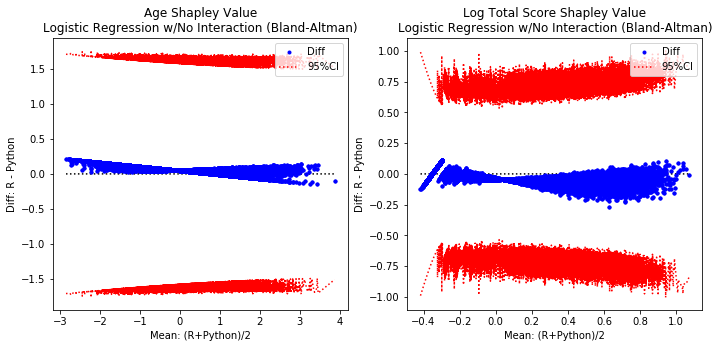

In [210]:
plt.figure(figsize=[18,5])
indModel=0

plt.subplot(1,3,1)
shapRef=listShap[indModel][:,0] # 0=age,1=score,2=score x age
shapCur=shap_value_lgr_file['age_shapley_fixed']
shapStd=np.sqrt(shap_value_lgr_file['age_shapley_var_fixed'])
shapAvg=(shapRef+shapCur)/2
indSort=np.argsort(shapAvg)
shapAvgSort=shapAvg[indSort]
shapDiffSort=shapCur[indSort]-shapRef[indSort]
shap95CISort=shapStd[indSort]*1.96
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.plot(shapAvgSort,shap95CISort,'r:');
plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
plt.plot(shapAvgSort,-shap95CISort,'r:');
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.xlabel('Mean: (R+Python)/2');
plt.ylabel('Diff: R - Python');
plt.legend(['Diff','95%CI'])
plt.title('Age Shapley Value\nLogistic Regression w/No Interaction (Bland-Altman)');

plt.subplot(1,3,2)
shapRef=listShap[indModel][:,1] # 0=age,1=score,2=score x age
shapCur=shap_value_lgr_file['log_cac_shapley_fixed']
shapStd=np.sqrt(shap_value_lgr_file['log_cac_shapley_var_fixed'])
shapAvg=(shapRef+shapCur)/2
indSort=np.argsort(shapAvg)
shapAvgSort=shapAvg[indSort]
shapDiffSort=shapCur[indSort]-shapRef[indSort]
shap95CISort=shapStd[indSort]*1.96
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.plot(shapAvgSort,shap95CISort,'r:');
plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
plt.plot(shapAvgSort,-shap95CISort,'r:');
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.xlabel('Mean: (R+Python)/2');
plt.ylabel('Diff: R - Python');
plt.legend(['Diff','95%CI'])
plt.title('Log Total Score Shapley Value\nLogistic Regression w/No Interaction (Bland-Altman)');

# plt.subplot(1,3,3)
# shapRef=listShap[indModel][:,2] # 0=age,1=score,2=score x age
# shapCur=np.zeros(shap_value_lgr_file.shape[0])
# shapStd=np.zeros(shap_value_lgr_file.shape[0])
# shapAvg=(shapRef+shapCur)/2
# indSort=np.argsort(shapAvg)
# shapAvgSort=shapAvg[indSort]
# shapDiffSort=shapCur[indSort]-shapRef[indSort]
# shap95CISort=shapStd[indSort]*1.96
# plt.plot(shapAvgSort,shapDiffSort,'b.');
# plt.plot(shapAvgSort,shap95CISort,'r:');
# plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
# plt.plot(shapAvgSort,-shap95CISort,'r:');
# plt.plot(shapAvgSort,shapDiffSort,'b.');
# plt.xlabel('Mean: (R+Python)/2');
# plt.ylabel('Diff: R - Python');
# plt.legend(['Diff','95%CI'])
# plt.title('Log Total Score x Age Shapley Value\nLogistic Regression (Bland-Altman)');


Creating legend with loc="best" can be slow with large amounts of data.


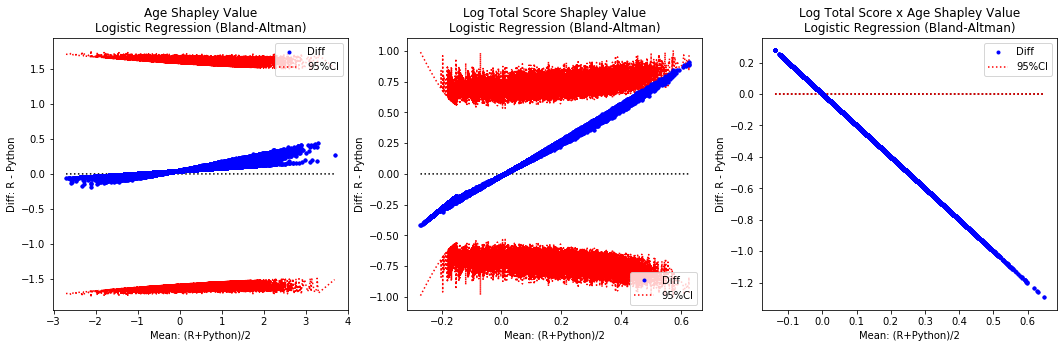

In [211]:
plt.figure(figsize=[18,5])
indModel=1

plt.subplot(1,3,1)
shapRef=listShap[indModel][:,0] # 0=age,1=score,2=score x age
shapCur=shap_value_lgr_file['age_shapley_fixed']
shapStd=np.sqrt(shap_value_lgr_file['age_shapley_var_fixed'])
shapAvg=(shapRef+shapCur)/2
indSort=np.argsort(shapAvg)
shapAvgSort=shapAvg[indSort]
shapDiffSort=shapCur[indSort]-shapRef[indSort]
shap95CISort=shapStd[indSort]*1.96
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.plot(shapAvgSort,shap95CISort,'r:');
plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
plt.plot(shapAvgSort,-shap95CISort,'r:');
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.xlabel('Mean: (R+Python)/2');
plt.ylabel('Diff: R - Python');
plt.legend(['Diff','95%CI'])
plt.title('Age Shapley Value\nLogistic Regression (Bland-Altman)');

plt.subplot(1,3,2)
shapRef=listShap[indModel][:,1] # 0=age,1=score,2=score x age
shapCur=shap_value_lgr_file['log_cac_shapley_fixed']
shapStd=np.sqrt(shap_value_lgr_file['log_cac_shapley_var_fixed'])
shapAvg=(shapRef+shapCur)/2
indSort=np.argsort(shapAvg)
shapAvgSort=shapAvg[indSort]
shapDiffSort=shapCur[indSort]-shapRef[indSort]
shap95CISort=shapStd[indSort]*1.96
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.plot(shapAvgSort,shap95CISort,'r:');
plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
plt.plot(shapAvgSort,-shap95CISort,'r:');
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.xlabel('Mean: (R+Python)/2');
plt.ylabel('Diff: R - Python');
plt.legend(['Diff','95%CI'])
plt.title('Log Total Score Shapley Value\nLogistic Regression (Bland-Altman)');

plt.subplot(1,3,3)
shapRef=listShap[indModel][:,2] # 0=age,1=score,2=score x age
shapCur=np.zeros(shap_value_lgr_file.shape[0])
shapStd=np.zeros(shap_value_lgr_file.shape[0])
shapAvg=(shapRef+shapCur)/2
indSort=np.argsort(shapAvg)
shapAvgSort=shapAvg[indSort]
shapDiffSort=shapCur[indSort]-shapRef[indSort]
shap95CISort=shapStd[indSort]*1.96
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.plot(shapAvgSort,shap95CISort,'r:');
plt.plot(shapAvgSort,np.zeros(shapAvgSort.shape),'k:');
plt.plot(shapAvgSort,-shap95CISort,'r:');
plt.plot(shapAvgSort,shapDiffSort,'b.');
plt.xlabel('Mean: (R+Python)/2');
plt.ylabel('Diff: R - Python');
plt.legend(['Diff','95%CI'])
plt.title('Log Total Score x Age Shapley Value\nLogistic Regression (Bland-Altman)');


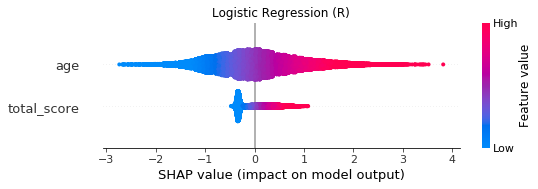

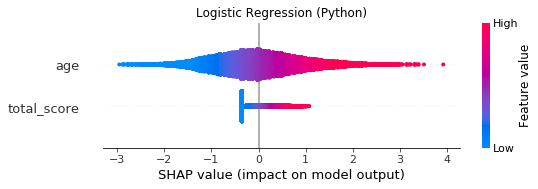

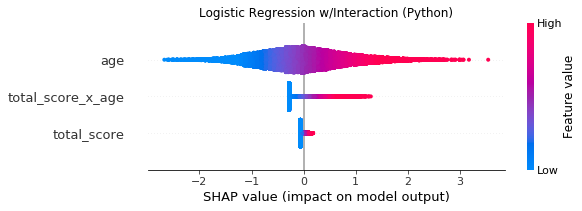

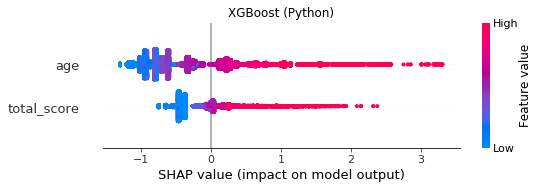

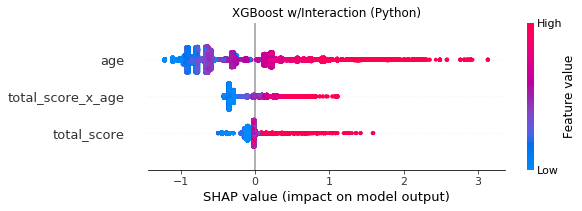

In [212]:
indModel=0
shapR=np.vstack((np.array(shap_value_lgr_file['age_shapley_fixed']),
                 np.array(shap_value_lgr_file['log_cac_shapley_fixed']))).T
plt.figure()
plt.title('Logistic Regression (R)')
shap.summary_plot(shapR,listDataTrain[indModel][:,:2],feature_names=listFeatureNames[indModel][0:2],show=False)
# plt.tight_layout()

indModel=0
plt.figure()
plt.title('Logistic Regression (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],show=False)
# plt.tight_layout()

indModel=1
plt.figure()
plt.title('Logistic Regression w/Interaction (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],show=False)
# plt.tight_layout()

indModel=2
plt.figure()
plt.title('XGBoost (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],show=False)
# plt.tight_layout()

indModel=3
plt.figure()
plt.title('XGBoost w/Interaction (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],show=False)
# plt.tight_layout()


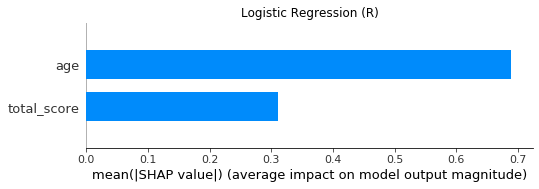

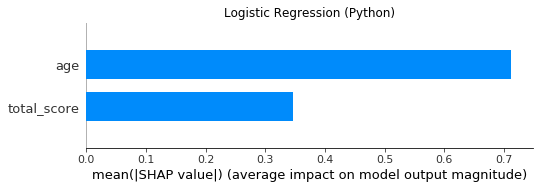

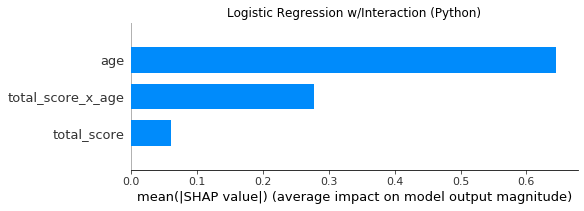

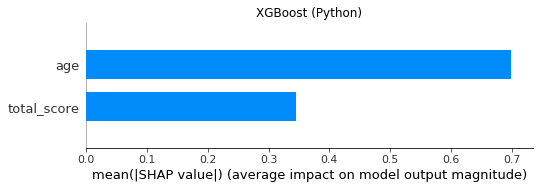

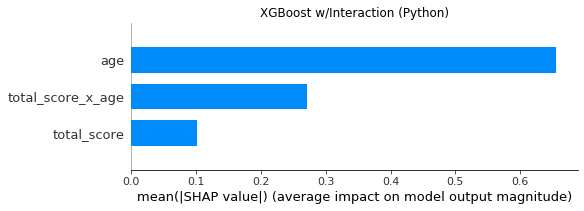

In [213]:
indModel=0
# shapR=np.vstack((np.array(shap_value_lgr_file['age_shapley_fixed']),
#                  np.array(shap_value_lgr_file['log_cac_shapley_fixed']))).T
# plt.figure()
plt.title('Logistic Regression (R)')
shap.summary_plot(shapR,listDataTrain[indModel][:,:2],feature_names=listFeatureNames[indModel][0:2],plot_type="bar")
# plt.tight_layout()

indModel=0
# plt.figure()
plt.title('Logistic Regression (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],plot_type="bar")
# plt.tight_layout()

indModel=1
# plt.figure()
plt.title('Logistic Regression w/Interaction (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],plot_type="bar")
# plt.tight_layout()

indModel=2
# plt.figure()
plt.title('XGBoost (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],plot_type="bar")
# plt.tight_layout()

indModel=3
# plt.figure()
plt.title('XGBoost w/Interaction (Python)')
shap.summary_plot(listShap[indModel],listDataTrain[indModel],feature_names=listFeatureNames[indModel],plot_type="bar")
# plt.tight_layout()


<Figure size 432x288 with 0 Axes>

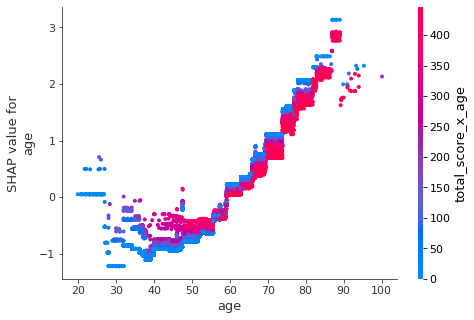

<Figure size 432x288 with 0 Axes>

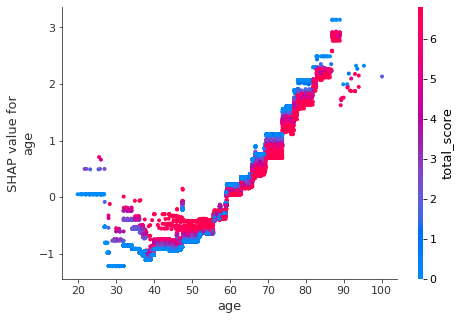

<Figure size 432x288 with 0 Axes>

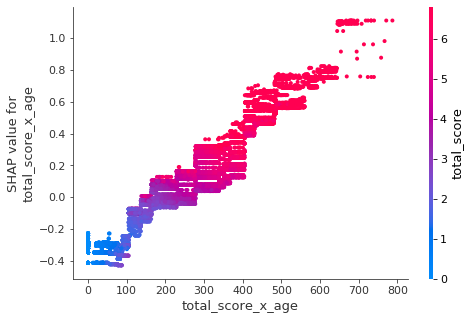

In [195]:
# for indModel in range(len(listShap)):
indModel=2
plt.figure()
shap.dependence_plot('age', listShap[indModel], listDataTrainUnnorm[indModel], 
                     interaction_index='total_score_x_age', feature_names=listFeatureNames[indModel])
plt.figure()
shap.dependence_plot('age', listShap[indModel], listDataTrainUnnorm[indModel], 
                     interaction_index='total_score', feature_names=listFeatureNames[indModel])
plt.figure()
shap.dependence_plot('total_score_x_age', listShap[indModel], listDataTrainUnnorm[indModel], 
                     interaction_index='total_score', feature_names=listFeatureNames[indModel])
